### Evaluate final U-Net models on CESM, FOCI and real world slp data

In [4]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
# Check current working directory:
print(os.getcwd())

/gxfs_work1/geomar/smomw511/GitHub/MarcoLandtHayen/reconstruct_missing_data/notebooks


In [6]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

In [7]:
## Specify parameters:

# Source: 'CESM', 'FOCI' or 'realworld'
source = 'realworld'
feature = 'sea-level-pressure'
feature_short = 'slp'

# Further parameters for pre-processing inputs and targets:
train_val_split = 0.8
scale_to = 'zero_one'


## Set paths to final models and set shortnames for final models:

if source == 'realworld':

    # realworld:
    paths_to_final_models=[
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_fixed_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_2_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_3_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_optimal_from_CESM_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_optimal_from_FOCI_discrete_factor_1_final',
    ]
    
    model_shortnames=[
        'mask: fixed',
        'mask: variable, factor: 1',
        'mask: variable, factor: 2',
        'mask: variable, factor: 3',
        'mask: optimal from CESM',
        'mask: optimal from FOCI',
    ]
    
else:
    
    paths_to_final_models=[
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_fixed_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_variable_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_variable_discrete_factor_2_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_variable_discrete_factor_3_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_optimal_discrete_factor_1_final',
    ]

    model_shortnames=[
        'mask: fixed',
        'mask: variable, factor: 1',
        'mask: variable, factor: 2',
        'mask: variable, factor: 3',
        'mask: optimal',
    ]

In [8]:
# Load train and validation loss per sample for first model, to infer number of training and validation samples, 
# lat and lon, and number of missing value rates. Do this from first experiment, since it has augmentation factor 1:
n_train=np.load(Path(paths_to_final_models[0]) / 'train_loss_per_sample_all.npy').shape[-1]
n_val=np.load(Path(paths_to_final_models[0]) / 'val_loss_per_sample_all.npy').shape[-1]
lat=np.load(Path(paths_to_final_models[0]) / 'train_loss_map_all.npy').shape[1]
lon=np.load(Path(paths_to_final_models[0]) / 'train_loss_map_all.npy').shape[2]
n_missing=np.load(Path(paths_to_final_models[0]) / 'train_loss_per_sample_all.npy').shape[0]

# Initialize storage for parameters:
feature_all = []
feature_short_all = []
source_all = []
mask_type_all = []
missing_type_all = []
augmentation_factor_all = []
missing_values_all = []

# Initialize storage for reloaded results, for all models and missing rates.
train_loss_per_sample_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
val_loss_per_sample_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
train_loss_map_all = np.zeros((len(paths_to_final_models),n_missing,lat,lon))
val_loss_map_all = np.zeros((len(paths_to_final_models),n_missing,lat,lon))
SAM_train_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
SAM_val_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
SAM_train_target_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
SAM_val_target_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
NAO_train_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
NAO_val_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
NAO_train_target_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
NAO_val_target_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
NP_train_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
NP_val_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
NP_train_target_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
NP_val_target_all = np.zeros((len(paths_to_final_models),n_missing,n_val))

# Loop over final models:
for i in range(len(paths_to_final_models)):
    
    # Get path to final model:
    path_to_final_model = paths_to_final_models[i]
    
    # Reload parameters for this experiment:
    with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
        parameters=load(f)

    # Store parameters:    
    feature_all.append(parameters['feature'])
    feature_short_all.append(parameters['feature_short'])
    source_all.append(parameters['source'])
    mask_type_all.append(parameters['mask_type'])
    missing_type_all.append(parameters['missing_type'])
    augmentation_factor_all.append(parameters['augmentation_factor'])
    missing_values_all.append(parameters['missing_values'])
    
    ## Reload results.
    ## Took augmentation factor into account in batch already. If data is used n times, only stored every n-th sample.
    ## Like this, we have equal dimensions for all augmentation factors and include each target only once.
    
    # Get number of missing value rates:
    n_missing = len(missing_values_all[-1])

    ## Reload results and filter:
    # Consider all missing value rates, although optimal model has only 99.9%, 99% and 95% missing values. 
    # And take each sample only once.
    # Note: Take n_train and n_val from first model. Due to rounding errors, can have slight variation. Force number of
    # samples to equal n_train and n_val from first model!
    train_loss_per_sample_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'train_loss_per_sample_all.npy')[:,:n_train]
    val_loss_per_sample_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'val_loss_per_sample_all.npy')[:,:n_val]
    train_loss_map_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'train_loss_map_all.npy')
    val_loss_map_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'val_loss_map_all.npy')
    SAM_train_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SAM_train_pred_all.npy')[:,:n_train]
    SAM_val_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SAM_val_pred_all.npy')[:,:n_val]
    SAM_train_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SAM_train_target_all.npy')[:,:n_train]
    SAM_val_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SAM_val_target_all.npy')[:,:n_val]
    NAO_train_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NAO_train_pred_all.npy')[:,:n_train]
    NAO_val_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NAO_val_pred_all.npy')[:,:n_val]
    NAO_train_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NAO_train_target_all.npy')[:,:n_train]
    NAO_val_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NAO_val_target_all.npy')[:,:n_val]
    NP_train_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NP_train_pred_all.npy')[:,:n_train]
    NP_val_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NP_val_pred_all.npy')[:,:n_val]
    NP_train_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NP_train_target_all.npy')[:,:n_train]
    NP_val_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NP_val_target_all.npy')[:,:n_val]

### Where does reconstruction fail?

Visualize the mean loss map averaged over all validation samples.

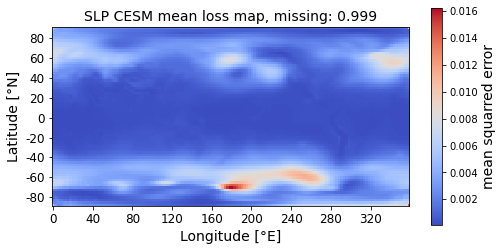

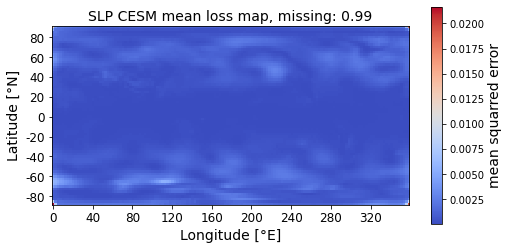

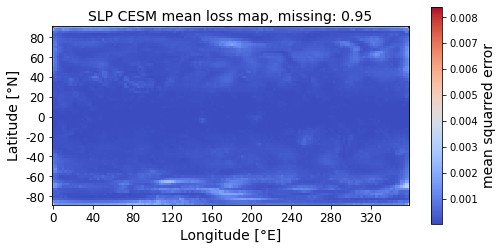

In [22]:
## slp RW: Optimal mask transferred from CESM

## Show mean loss maps averaged over all validation samples for various rates of missing values.

# Set number of missing rates to include:
n_missing_rates = 3

# Choose model number:
model_n = 4 # Transferred from CESM

# Loop over rates of missing values:
for r in range(n_missing_rates):
    
    # Plot mean rel. loss map as heatmap:        
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(val_loss_map_all[model_n,r], cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
    cbar = plt.colorbar(im)
    cbar.set_label('mean squarred error', fontsize=14)
    plt.title('SLP CESM mean loss map, missing: '+str(missing_values_all[model_n][r]), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

### Indices (SAM, NAO, NP) on reconstructed vs. complete fields

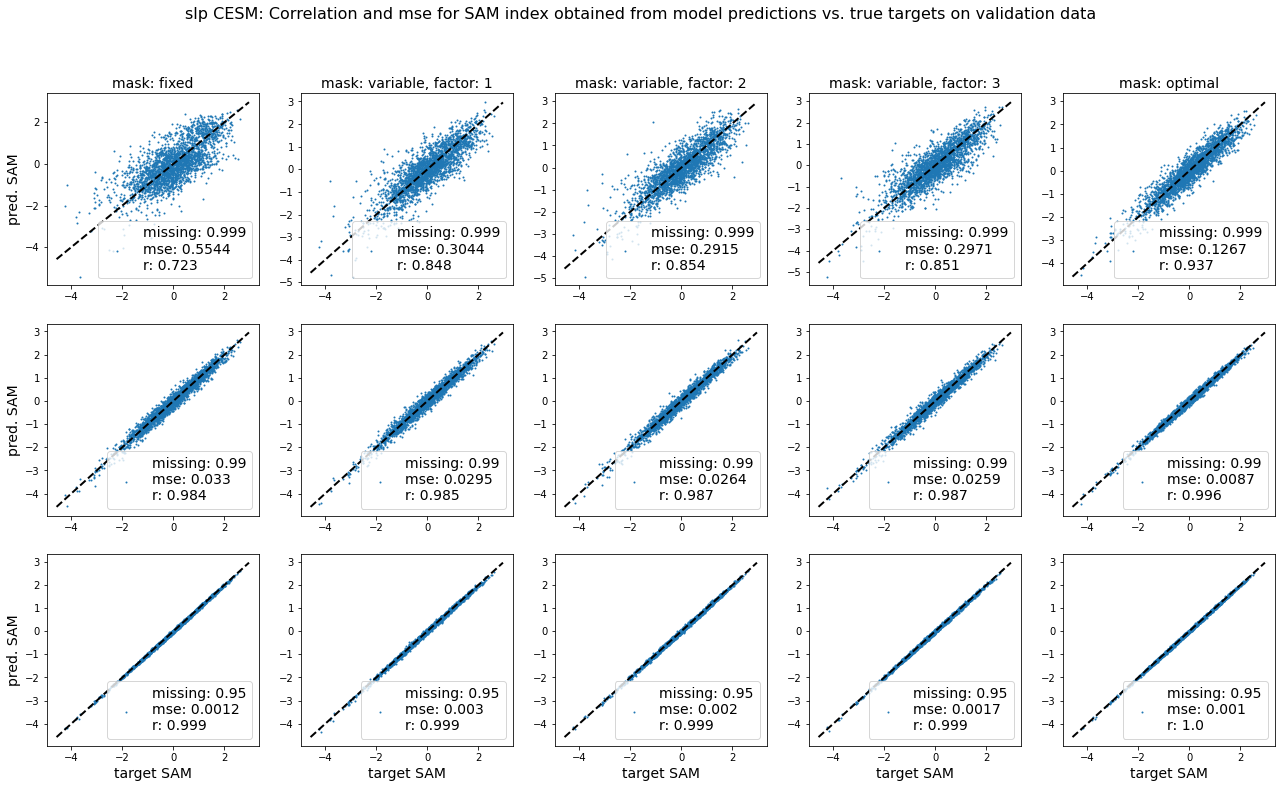

In [32]:
## slp CESM

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for SAM:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(SAM_val_target_all[model_number,r,:n_samples], SAM_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((SAM_val_target_all[model_number,r,:n_samples]-SAM_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([SAM_val_target_all[model_number,r,:n_samples],SAM_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target SAM', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. SAM', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp CESM: Correlation and mse for SAM index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

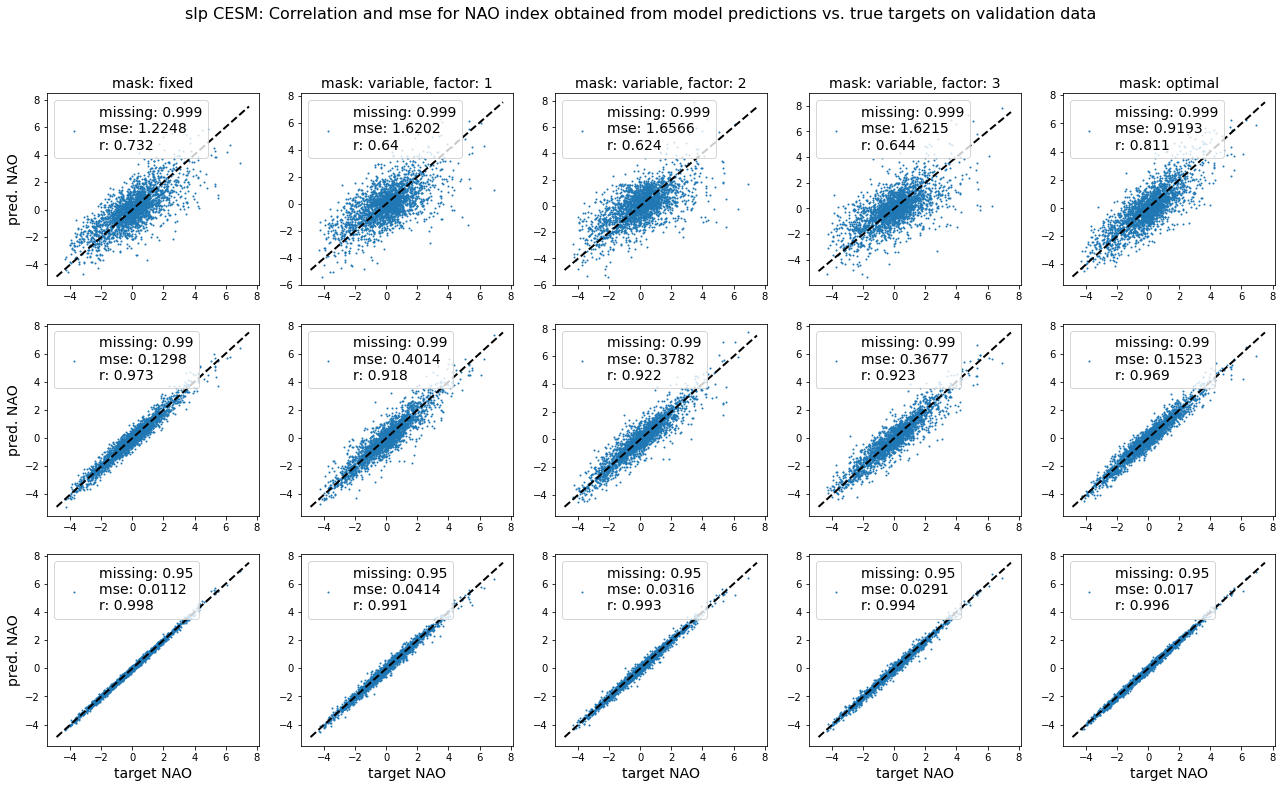

In [33]:
# Initialize plot for NAO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NAO_val_target_all[model_number,r,:n_samples], NAO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NAO_val_target_all[model_number,r,:n_samples]-NAO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NAO_val_target_all[model_number,r,:n_samples],NAO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NAO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NAO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)        
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp CESM: Correlation and mse for NAO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

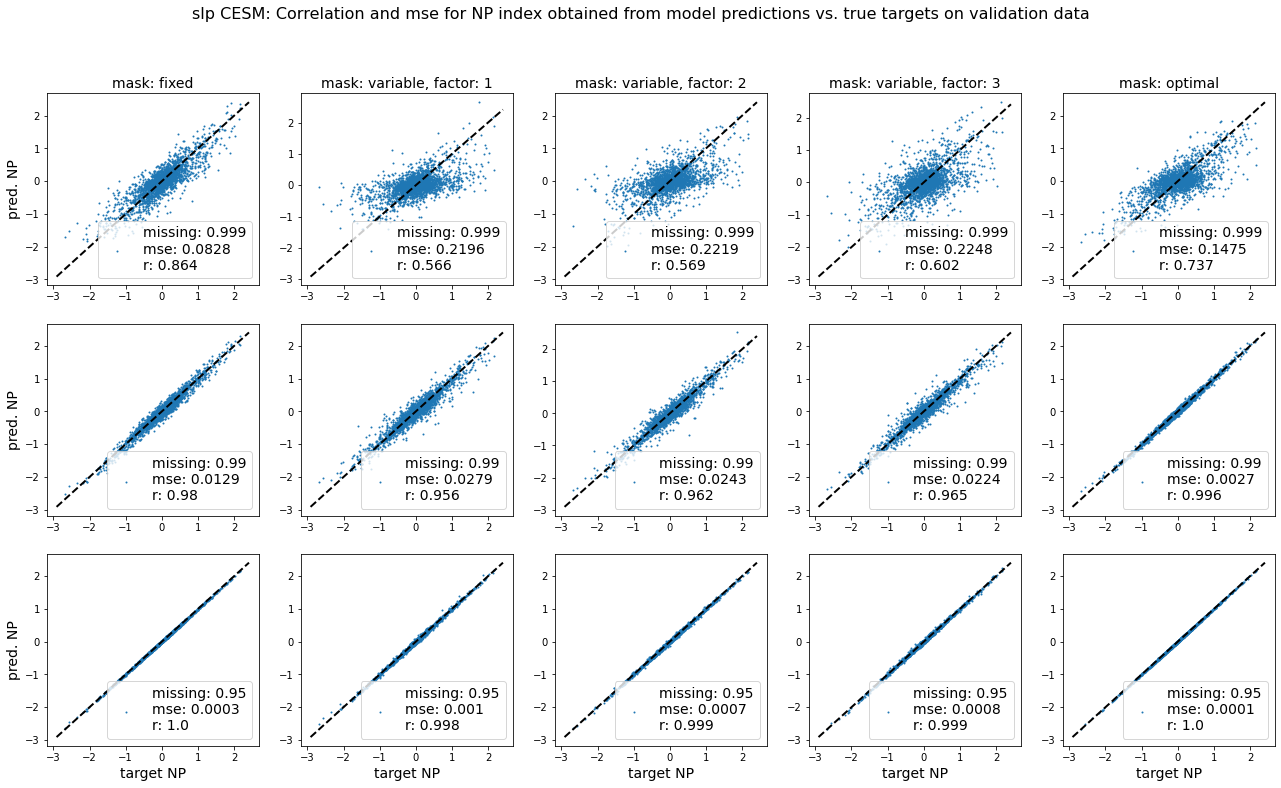

In [34]:
# Initialize plot for NP:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NP_val_target_all[model_number,r,:n_samples], NP_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NP_val_target_all[model_number,r,:n_samples]-NP_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NP_val_target_all[model_number,r,:n_samples],NP_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NP', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NP', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
                
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp CESM: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

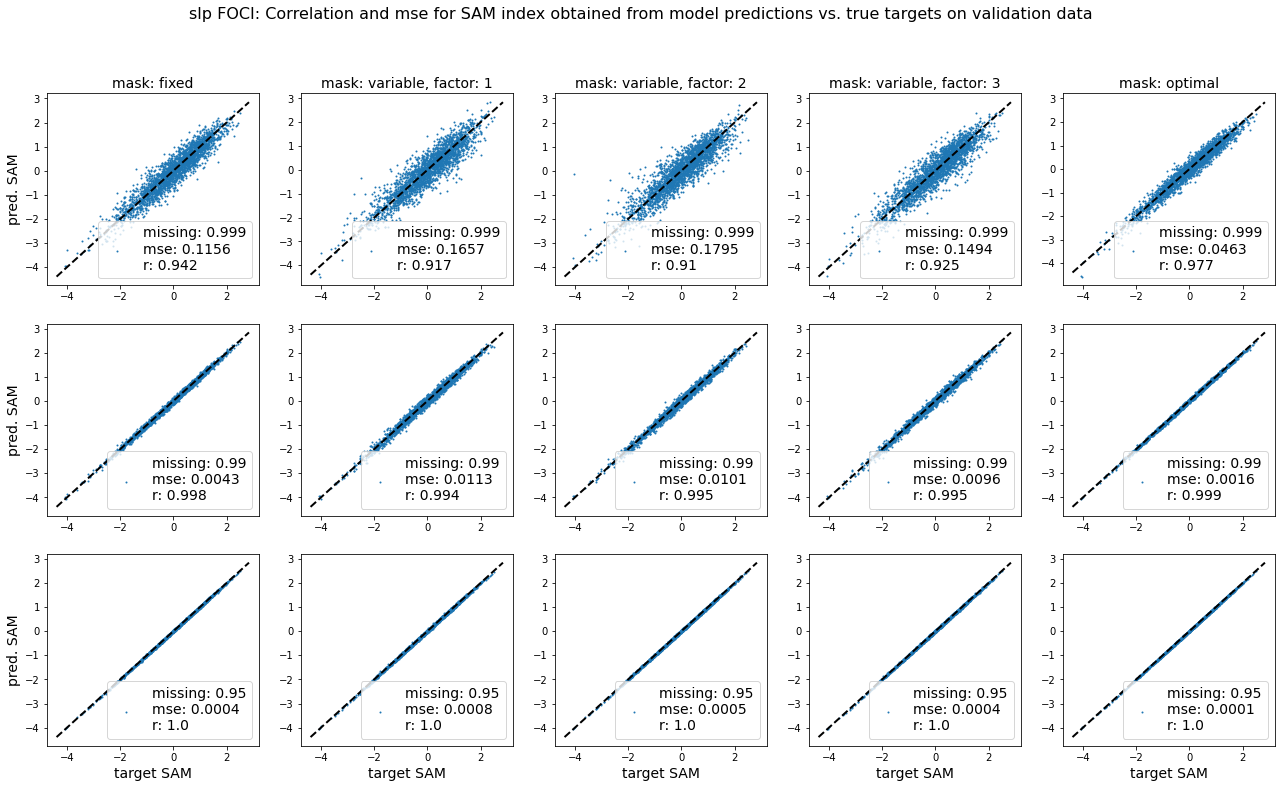

In [38]:
## slp FOCI

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for SAM:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(SAM_val_target_all[model_number,r,:n_samples], SAM_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((SAM_val_target_all[model_number,r,:n_samples]-SAM_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([SAM_val_target_all[model_number,r,:n_samples],SAM_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target SAM', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. SAM', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
                        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp FOCI: Correlation and mse for SAM index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

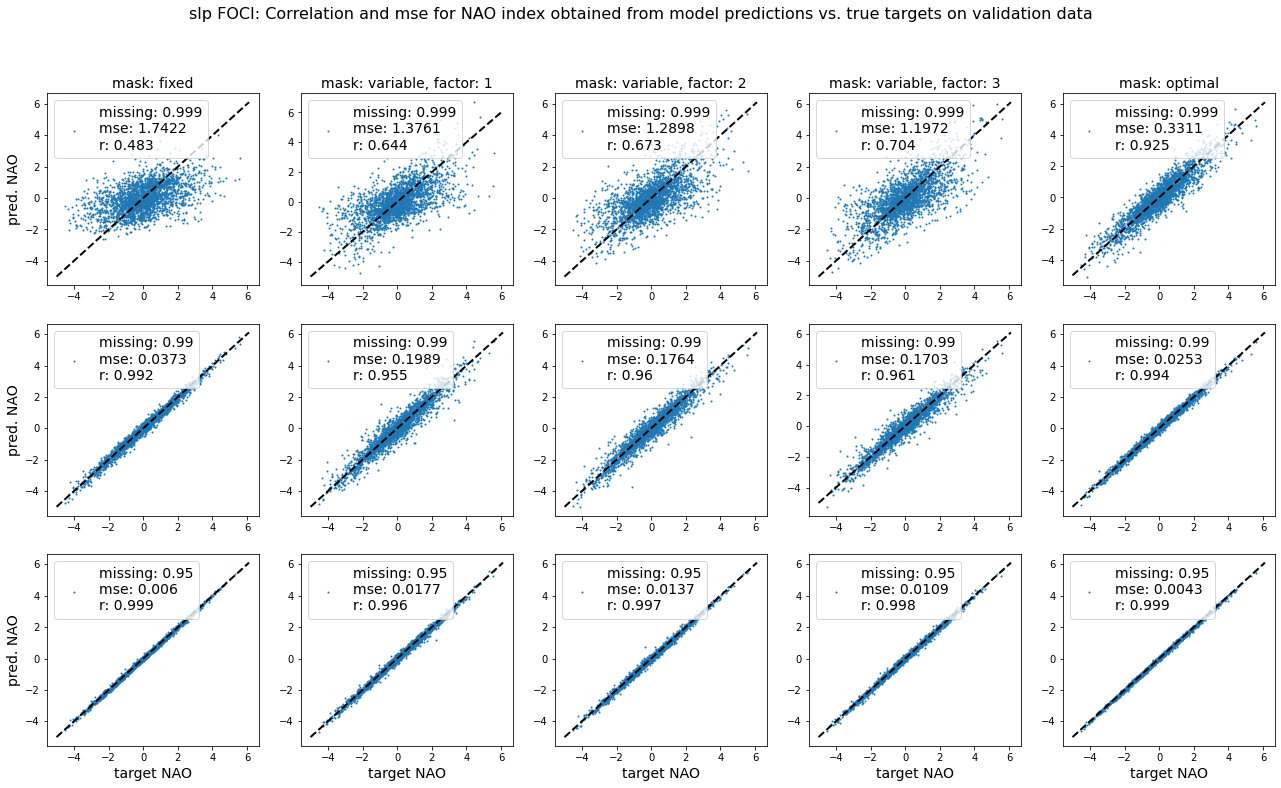

In [39]:
# Initialize plot for NAO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NAO_val_target_all[model_number,r,:n_samples], NAO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NAO_val_target_all[model_number,r,:n_samples]-NAO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NAO_val_target_all[model_number,r,:n_samples],NAO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NAO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NAO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
                
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp FOCI: Correlation and mse for NAO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

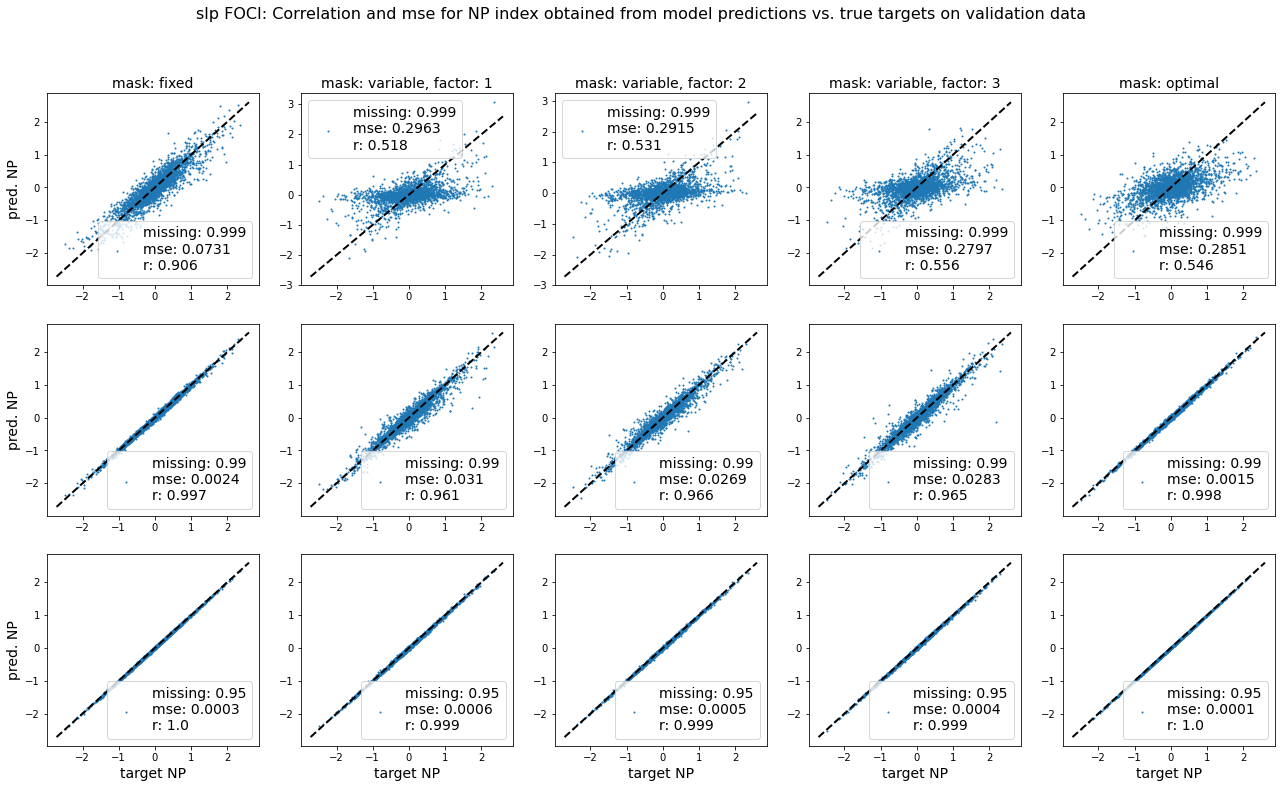

In [40]:
# Initialize plot for NP:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NP_val_target_all[model_number,r,:n_samples], NP_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NP_val_target_all[model_number,r,:n_samples]-NP_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NP_val_target_all[model_number,r,:n_samples],NP_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NP', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NP', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
                
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp FOCI: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

Text(0.5, 0.98, 'slp real world: Correlation and mse for SAM index obtained from model predictions vs. true targets on validation data')

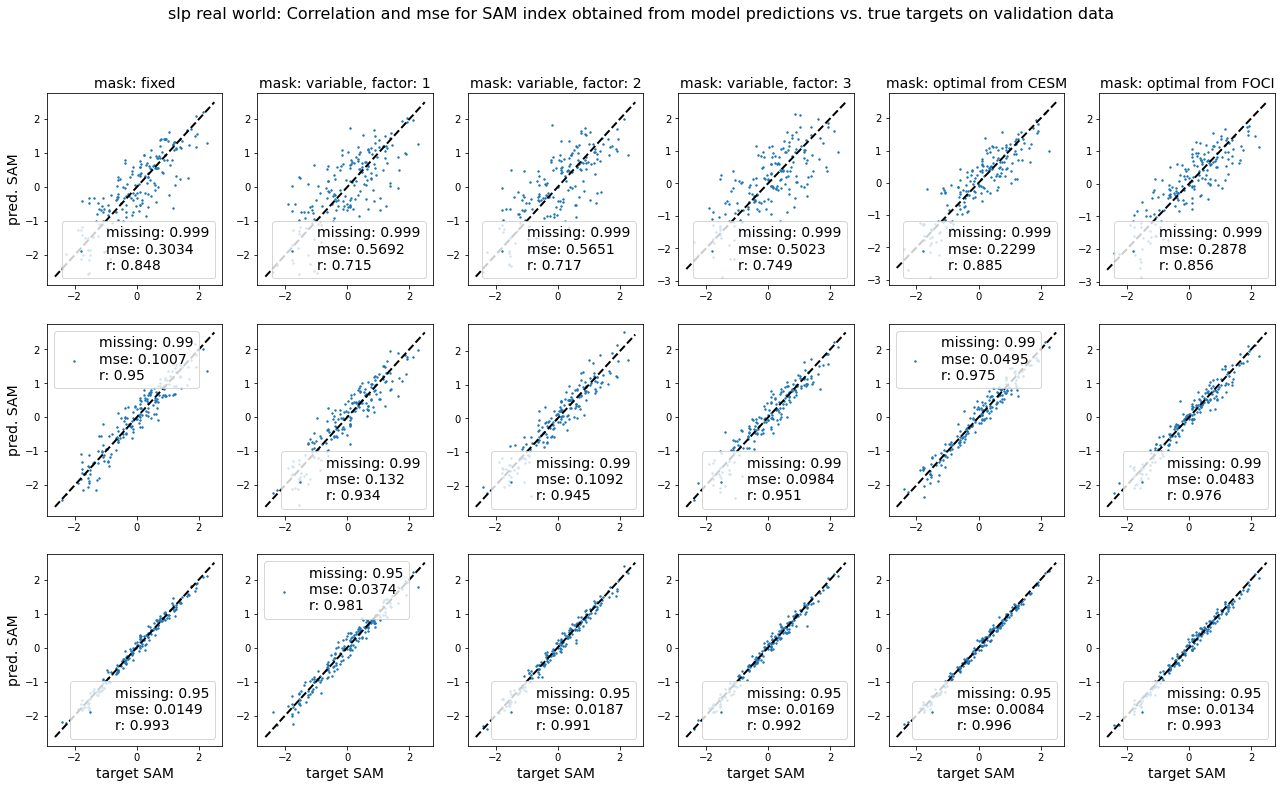

In [132]:
## slp real world

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for SAM:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(SAM_val_target_all[model_number,r,:n_samples], SAM_val_pred_all[model_number,r,:n_samples], s=2,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((SAM_val_target_all[model_number,r,:n_samples]-SAM_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([SAM_val_target_all[model_number,r,:n_samples],SAM_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target SAM', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. SAM', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp real world: Correlation and mse for SAM index obtained from model predictions vs. true targets on validation data', fontsize=16)

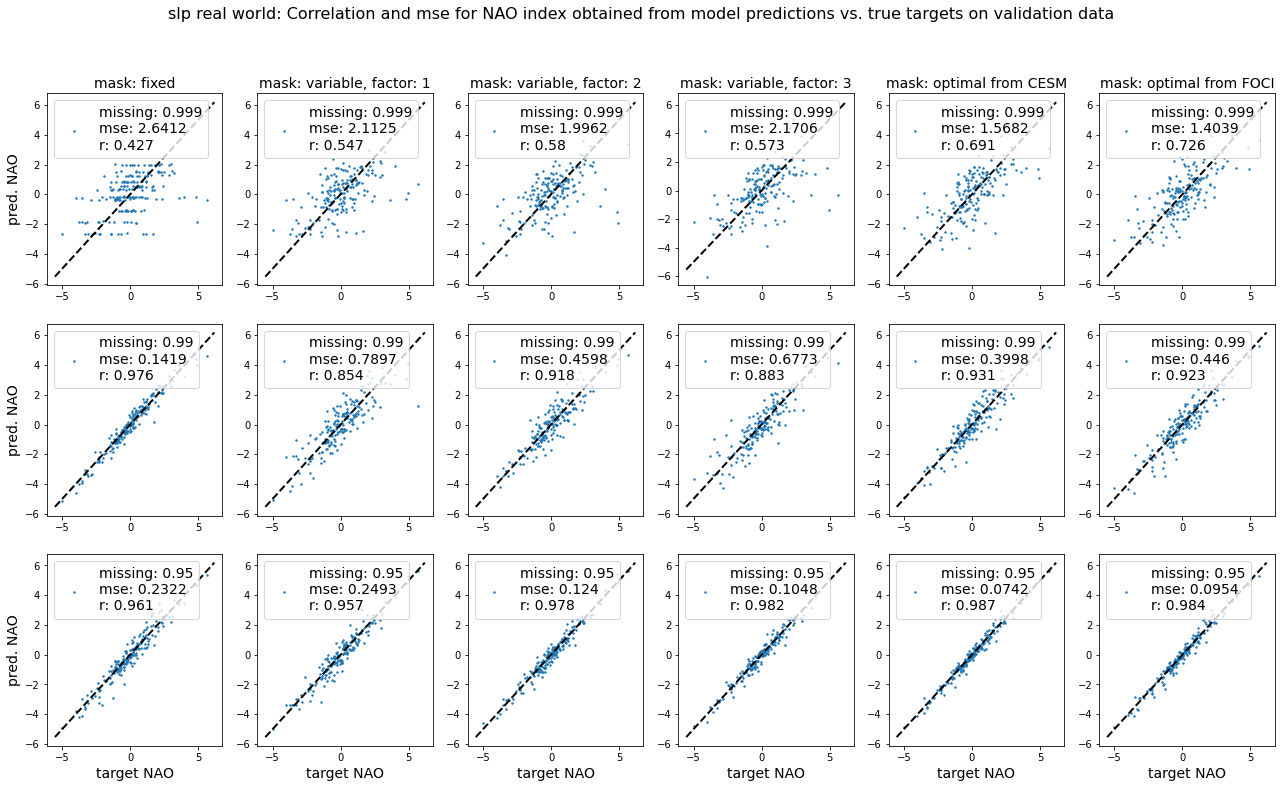

In [7]:
# Initialize plot for NAO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NAO_val_target_all[model_number,r,:n_samples], NAO_val_pred_all[model_number,r,:n_samples], s=2,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NAO_val_target_all[model_number,r,:n_samples]-NAO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NAO_val_target_all[model_number,r,:n_samples],NAO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NAO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NAO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp real world: Correlation and mse for NAO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

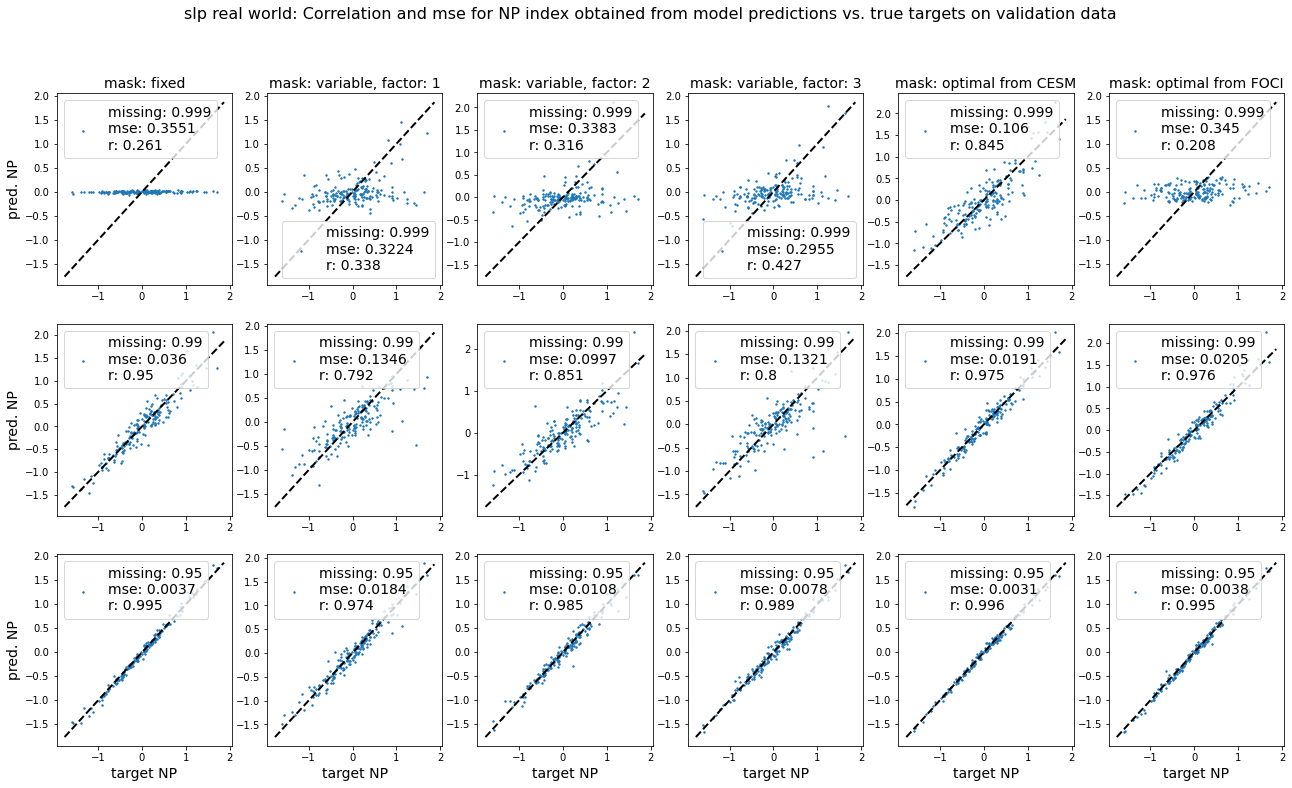

In [8]:
# Initialize plot for NP:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NP_val_target_all[model_number,r,:n_samples], NP_val_pred_all[model_number,r,:n_samples], s=2,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NP_val_target_all[model_number,r,:n_samples]-NP_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NP_val_target_all[model_number,r,:n_samples],NP_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NP', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NP', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp real world: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

### Find samples that clearly show outperformance of optimal models for reconstructing from ultra sparse inputs

In [8]:
## Load data, get anomalies:

if source=='realworld':
    
    # Specify path to data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"
    
    # Open data set:
    slp_dataset=xr.open_dataset(path_to_data)

    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    slp_fields = (
        slp_dataset.pres
        .sel(time=slice('1948-01-01', '2022-12-01'))
    )
    
    # Compute monthly climatology (here 1980 - 2009) for whole world:
    slp_climatology_fields = (
        slp_dataset.pres
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields
    
    # When working with complete samples in spatial extend:
    # Remove last row (latidute), to have even number of steps in latitude (=72). This served as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    # This step is not essential for EOF, but keep it similar to U-Net approach.
    feature_anomaly = slp_anomaly_fields.values[:,:-1,:]
    
else:

    # Specify path to data: 
    data_path='climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=data_path, data_source_name=source)

    # Extract feature:
    feature_raw = data[feature]
    
    # Remove seasonal cycle to get anomalies, use whole time span as climatology:
    climatology = feature_raw.groupby("time.month").mean("time")
    feature_anomaly = (feature_raw.groupby("time.month") - climatology).drop("month")[:n_time,:n_lat,:n_lon]

In [9]:
# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = (np.ones(feature_anomaly.shape)==1)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
_, val_input, _, val_target, train_min, train_max, _, _ = split_and_scale_data(
    feature_anomaly, 
    missing_mask_1,
    train_val_split=train_val_split, 
    scale_to=scale_to
)

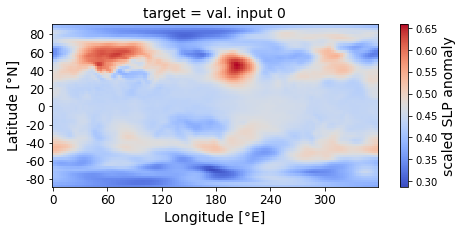

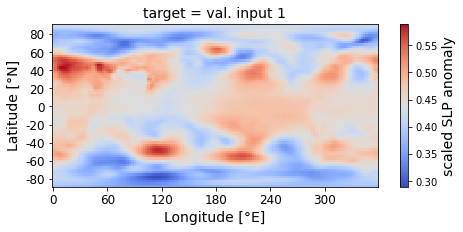

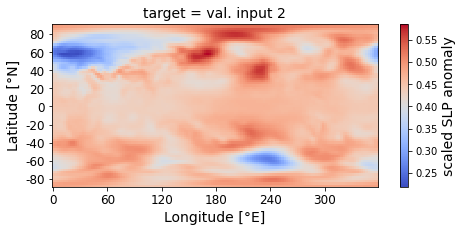

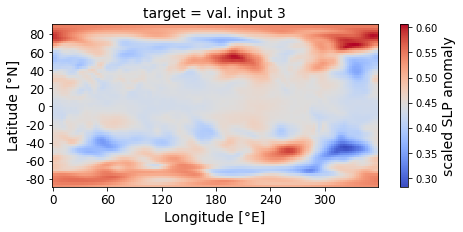

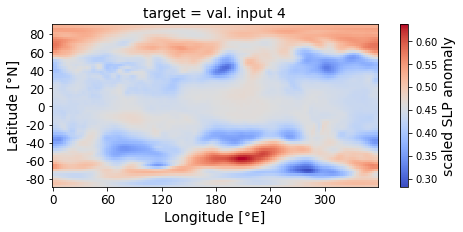

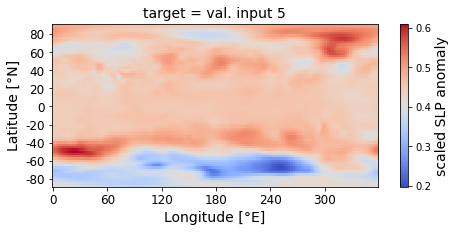

In [10]:
## Plot some validation targets (=complete samples):

# Specify number of samples to consider:
n_samples = 6

# Loop over samples:
for n in range(n_samples):
    
    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_target[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

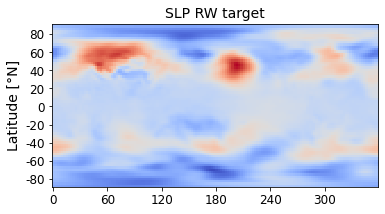

In [25]:
## Plot single target:

# Pick sample number:
sample = 0

# Plot:
fig, ax = plt.subplots(figsize=(7, 3))
im = plt.imshow(val_target[sample], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label("Scaled SLP anomaly", fontsize=14)
plt.title('SLP RW target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

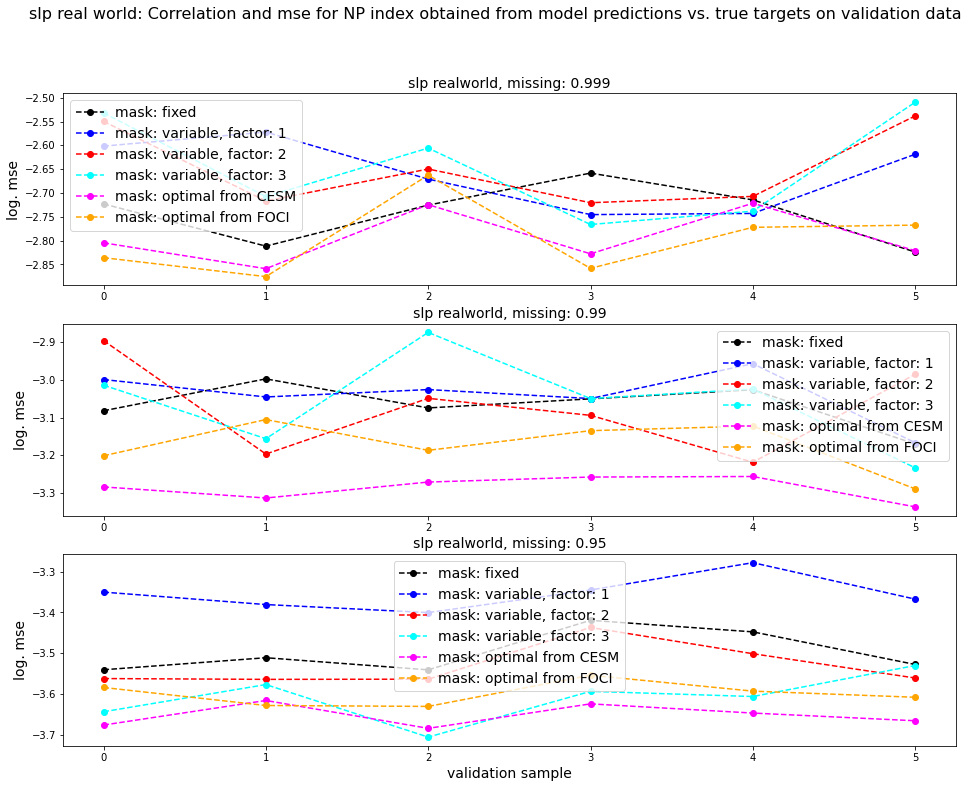

In [29]:
## Plot val. loss for several validation samples for all models and specified rates of missing values:

# Set number of missing rates to include:
n_missing_rates = 3

# Set colors and linestyles for individual models:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'orange']
linestyles = ['--', '--', '--', '--', '--', '--']

# Initialize plot:
fig, axes = plt.subplots(n_missing_rates,1,figsize=(16,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r].plot(
            np.log10(val_loss_per_sample_all[model_number,r,:n_samples]),
            color=colors[model_number],
            label=model_shortnames[model_number],
            marker = 'o', linestyle = linestyles[model_number],
        )
                
        axes[r].set_title(feature_short+' '+source+', missing: '+str(missing_values_all[model_number][r]), fontsize=14)
        if r == n_missing_rates-1:
            axes[r].set_xlabel('validation sample', fontsize=14)
        axes[r].set_ylabel('log. mse', fontsize=14)
        axes[r].legend(fontsize=14)

fig.suptitle('slp real world: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

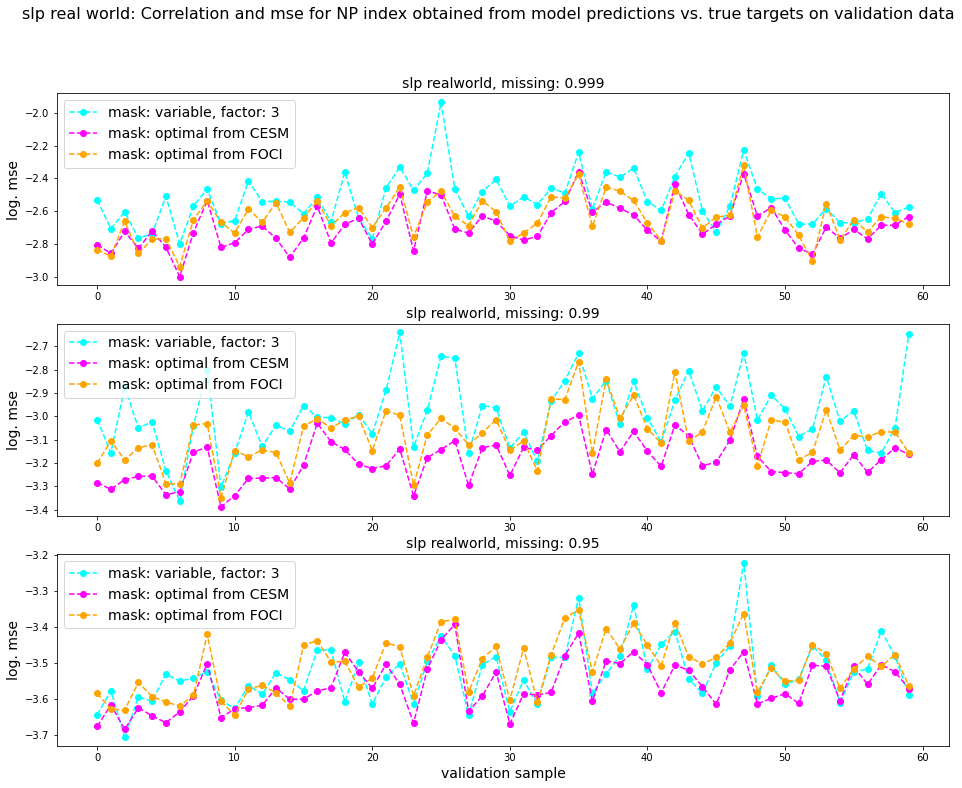

In [30]:
## Plot val. loss for selected validation samples for optimal models and model trained on variable mask with factor 3
## and specified rates of missing values:

# Specify start sample and number of samples:
start_sample = 0
n_samples = 60


# Set number of missing rates to include:
n_missing_rates = 3

# Set colors and linestyles for individual models:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'orange']
linestyles = ['--', '--', '--', '--', '--', '--']

# Initialize plot:
fig, axes = plt.subplots(n_missing_rates,1,figsize=(16,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in np.arange(3,len(model_shortnames)):

        axes[r].plot(
            np.arange(start_sample,start_sample+n_samples),
            np.log10(val_loss_per_sample_all[model_number,r,start_sample:start_sample+n_samples]),
            color=colors[model_number],
            label=model_shortnames[model_number],
            marker = 'o', linestyle = linestyles[model_number],
        )
                
        axes[r].set_title(feature_short+' '+source+', missing: '+str(missing_values_all[model_number][r]), fontsize=14)
        if r == n_missing_rates-1:
            axes[r].set_xlabel('validation sample', fontsize=14)
        axes[r].set_ylabel('log. mse', fontsize=14)
        axes[r].legend(fontsize=14)

fig.suptitle('slp real world: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

In [27]:
## Pick validation sample:
sample_number = 0

## Pick rate of missing values:
r = 1

# Get current rate of missing values:
missing = missing_values_all[0][r]
print('missing: ',missing)

missing:  0.99


In [28]:
# Initialize storage for model predictions. Dimension: (1,#models, lat, lon)
sample_pred_all = np.zeros((1,len(paths_to_final_models),val_input.shape[1],val_input.shape[2]))

# Loop over number of final models:
for m in range(len(paths_to_final_models)):
    
    # Get status:
    print('  model ',m+1,' of ',len(paths_to_final_models))
    
    # Get current augmentation factor:
    augmentation_factor = augmentation_factor_all[m]
    
    # Real world data needs separate pre-processing:
    if source == 'realworld':

        # Path to full data:
        path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"  

        ## Load data:

        # Open data set:
        slp_dataset=xr.open_dataset(path_to_data)

        # Extract time, latitude and longitude dimensions.
        # Already consider, that time dimension and latitude are sliced below: Omit last entry, in either case.
        time = slp_dataset['time'][:-1]
        latitude = slp_dataset['lat'][:-1]
        longitude = slp_dataset['lon']

        # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
        slp_fields = (
            slp_dataset.pres
            .sel(time=slice('1948-01-01', '2022-12-01'))
        )

        # Get number of train and validation samples: Consider augmentation factor!
        n_train = int(len(slp_fields) * augmentation_factor * train_val_split)
        n_val = ((len(slp_fields) * augmentation_factor) - n_train)

        # Compute monthly climatology (here 1980 - 2009) for whole world:
        slp_climatology_fields = (
            slp_dataset.pres
            .sel(time=slice('1980-01-01','2009-12-01'))
            .groupby("time.month")
            .mean("time")
        )

        # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
        slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields

        # Remove last row (latidute), to have equal number of steps in latitude (=72). This serves as 'quick-and-dirty'
        # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
        slp_anomaly_fields = slp_anomaly_fields.values[:,:-1,:]

        # Extend data, if desired:
        data = clone_data(data=slp_anomaly_fields, augmentation_factor=augmentation_factor)

    else:

        # Path to full data:
        path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

        # Load data:
        data = load_data_set(data_path=path_to_data, data_source_name=source)

        # Extract time, latitude and longitude dimensions:
        time = data['time']
        latitude = data['lat']
        longitude = data['lon']

        # Get number of train and validation samples: Consider augmentation factor!
        n_train = int(len(data[feature]) * augmentation_factor * train_val_split)
        n_val = ((len(data[feature]) * augmentation_factor) - n_train)

        # Compute monthly climatology over complete time span for whole world:
        slp_climatology_fields = data[feature].groupby("time.month").mean("time")

        # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
        slp_anomaly_fields = data[feature].groupby("time.month") - slp_climatology_fields

        # Extend data, if desired:
        data = clone_data(data=slp_anomaly_fields, augmentation_factor=augmentation_factor)
    

    ## Reconstruct sparse data (as inputs) and complete data (as targets).

    # Reload mask for missing values.
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing==0.999:
        missing_mask = np.load(Path(paths_to_final_models[m]) / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
    else:
        missing_mask = np.load(Path(paths_to_final_models[m]) / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        missing_mask, 
        train_val_split, 
        scale_to
    )

    # Reduce inputs and targets, use each sample only once. Augmentation factor determines step size:
#    train_input = train_input[np.arange(0,n_train,augmentation_factor)]
    val_input = val_input[np.arange(0,n_val,augmentation_factor)]
#    train_target = train_target[np.arange(0,n_train,augmentation_factor)]
    val_target = val_target[np.arange(0,n_val,augmentation_factor)]

    
    # Pick desired sample and target:
    sample = val_input[sample_number:sample_number+1]

    ## Reload final pre-trained model for current rate of missing values.

    # Set path:
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing==0.999:
        model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*1000)}" + "/model"
    else:
        model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*100)}" + "/model"

    # Reload model
    model = tf.keras.models.load_model(Path(model_path))

    # Get model prediction for desired sample and 
    # store model prediction for current final model and current rate of missing values:
    sample_pred_all[0,m] = model.predict(sample)[0,:,:,0]

  model  1  of  6
  model  2  of  6
  model  3  of  6
  model  4  of  6
  model  5  of  6
  model  6  of  6


In [32]:
## Store reconstructions for all models and current sample with current rate of missing values:

# Set path to store results:
path_to_store_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_realworld_reconstruction')

# Set filename, rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:
    file_name_sample_pred_all = "sample_pred_all_sample_"+str(sample_number)+"_missing_" f"{int(missing*1000)}"+".npy"
else:
    file_name_sample_pred_all = "sample_pred_all_sample_"+str(sample_number)+"_missing_" f"{int(missing*100)}"+".npy"
    
# Save reconstructions:
#np.save(path_to_store_results / file_name_sample_pred_all, sample_pred_all)

# Reload reconstructions:
# sample_pred_all = np.load(path_to_store_results / file_name_sample_pred_all)

0.99  missing

log(mse):  -3.08 



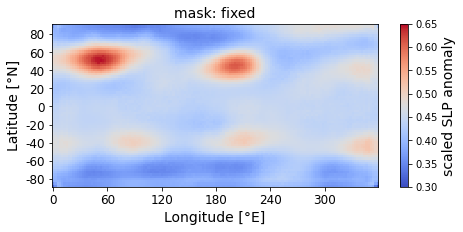

log(mse):  -3.0 



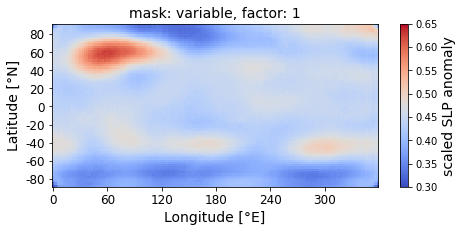

log(mse):  -2.9 



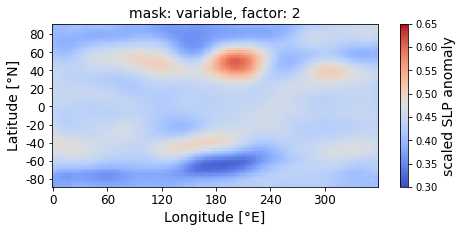

log(mse):  -3.01 



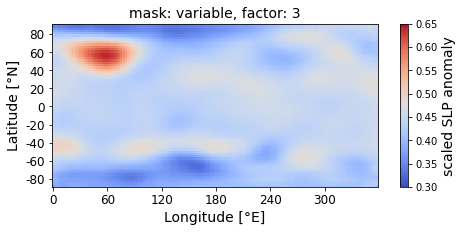

log(mse):  -3.28 



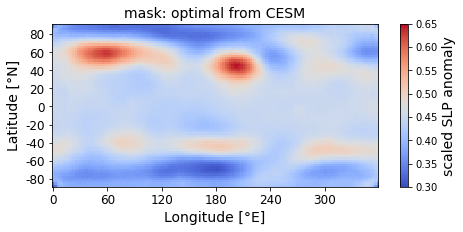

log(mse):  -3.2 



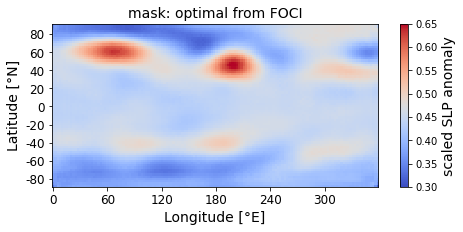

In [33]:
# Plot for specific rate of missing values all reconstructions from final models plus target.
# Plot - if available - DINEOF reconstruction (99% and 95% missing, only).

# Print current rate of missing values:
print(missing_values_all[0][r],' missing\n')

# Loop over models:
for m in range(len(model_shortnames)):
    
    # Print loss:
    print('log(mse): ',np.round(np.log10(np.mean((sample_pred_all[0,m]-val_target[sample_number])**2)),2),'\n')

#     ## Plot target:
#     fig, ax = plt.subplots(figsize=(7, 3))
#     im = plt.imshow(val_target[sample_number], cmap="coolwarm", interpolation='nearest', vmin=0.30, vmax=0.65)
#     cbar = plt.colorbar(im)
#     cbar.set_label("scaled SLP anomaly", fontsize=14)
#     plt.title('sample '+str(sample_number)+' target', fontsize=14)
#     plt.xlabel('Longitude [°E]', fontsize=14)
#     plt.ylabel('Latitude [°N]', fontsize=14)
#     plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
#     plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
#     plt.show()

    # Plot model reconstructions for current final model:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(sample_pred_all[0,m], cmap="coolwarm", interpolation='nearest', vmin=0.3, vmax=0.65)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title(model_shortnames[m], fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()


0.99  missing

log(mse):  -3.08 



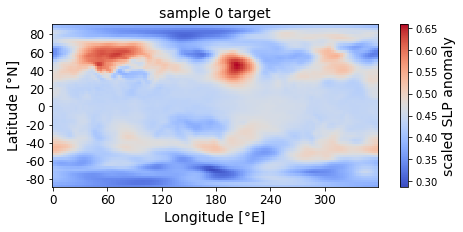

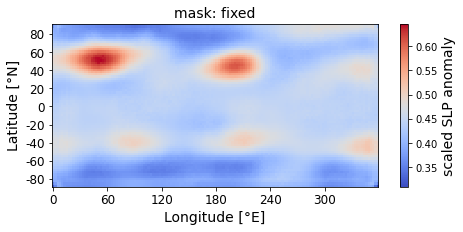

log(mse):  -3.0 



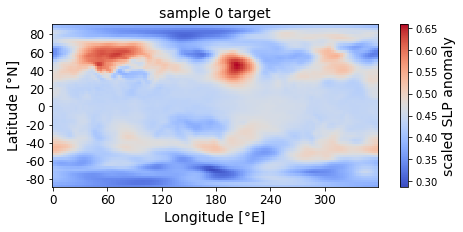

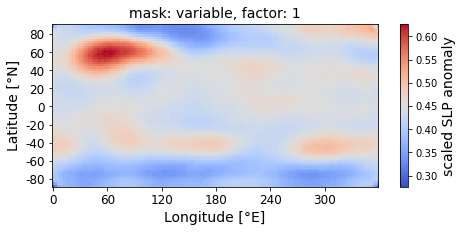

log(mse):  -2.9 



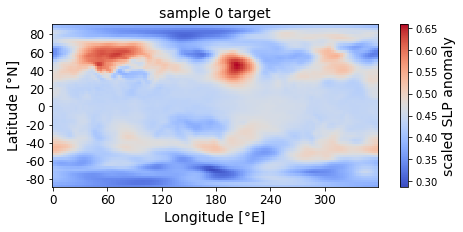

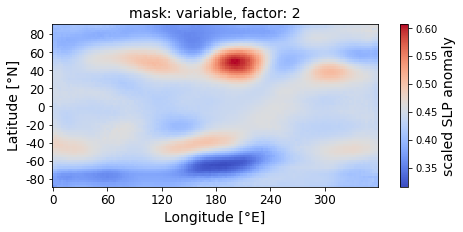

log(mse):  -3.01 



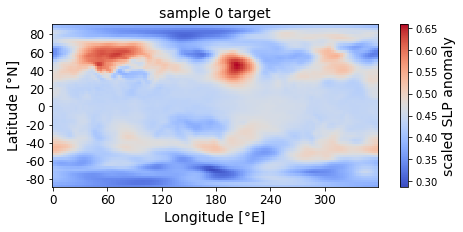

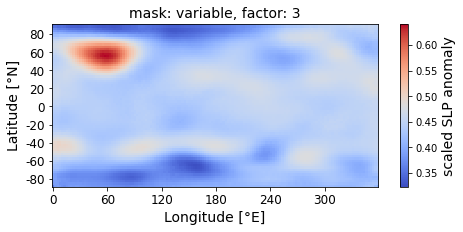

log(mse):  -3.28 



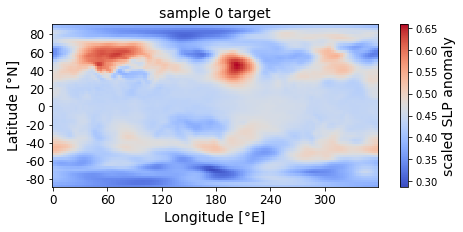

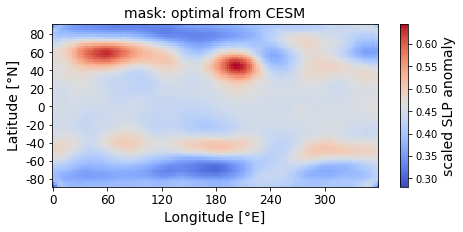

log(mse):  -3.2 



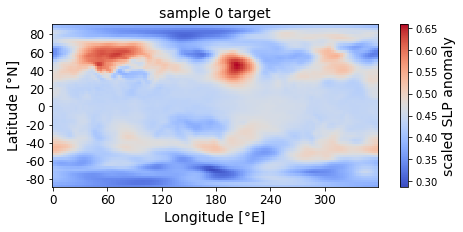

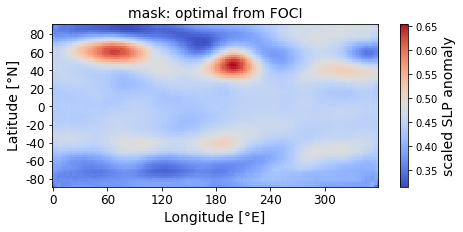

In [33]:
# Plot for specific rate of missing values all reconstructions from final models plus target.
# Plot - if available - DINEOF reconstruction (99% and 95% missing, only).

# Print current rate of missing values:
print(missing_values_all[0][r],' missing\n')

# Loop over models:
for m in range(len(model_shortnames)):
    
    # Print loss:
    print('log(mse): ',np.round(np.log10(np.mean((sample_pred_all[0,m]-val_target[sample_number])**2)),2),'\n')

    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_target[sample_number], cmap="coolwarm", interpolation='nearest')#, vmin=0.30, vmax=0.60)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title('sample '+str(sample_number)+' target', fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

    # Plot model reconstructions for current final model:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(sample_pred_all[0,m], cmap="coolwarm", interpolation='nearest')#, vmin=0.3, vmax=0.60)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title(model_shortnames[m], fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()
